In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
from skimage import transform
from skimage import io
from skimage.color import rgb2gray
import tqdm
import IPython
import copy
import pickle
import matplotlib as mpl
import pandas as pd

import torch
from torch import nn
import torch.optim as optim
from torchsummary import summary
from torch.optim import lr_scheduler
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import classification_report, confusion_matrix


from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torch.utils.data.sampler import WeightedRandomSampler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
full_dir = '/content/drive/MyDrive/Proyecto NMA/Resized images/tea_sickness_dataset_reduced/tea_sickness_dataset'
train_dir = '/content/drive/MyDrive/Proyecto NMA/Split_dataset/data_train'
val_dir = '/content/drive/MyDrive/Proyecto NMA/Split_dataset/data_val'
test_dir = '/content/drive/MyDrive/Proyecto NMA/Split_dataset/data_test'
class_names = os.listdir(full_dir)
num_class = len(class_names)

In [ ]:
image_files_full = [[os.path.join(full_dir, class_name, x) 
               for x in os.listdir(os.path.join(full_dir, class_name))] 
               for class_name in class_names]
image_file_full_list = []
image_label_full_list = []
for i, class_name in enumerate(class_names):
    image_count = len(image_files_full[i])
    print(f"Images in class {class_name}:",image_count)
    image_file_full_list.extend(image_files_full[i])
    image_label_full_list.extend([i] * len(image_files_full[i]))
#image_file_list.remove('tea sickness dataset/red leaf spot/.DS_Store')
num_total = len(image_label_full_list)
print("Total images:", num_total)
# inicialmente 886

Images in class Anthracnose: 99
Images in class bird eye spot: 100
Images in class brown blight: 113
Images in class healthy: 73
Images in class gray light: 98
Images in class red leaf spot: 143
Images in class white spot: 141
Images in class algal leaf: 113
Total images: 880


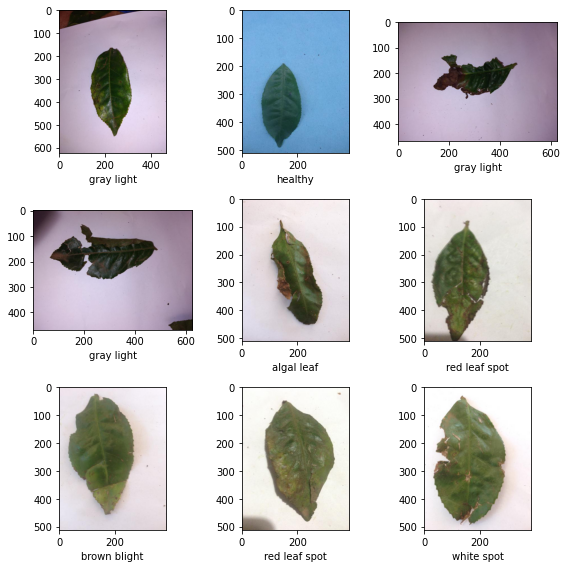

In [ ]:
plt.subplots(3,3, figsize=(8,8))
for i,k in enumerate(np.random.randint(num_total, size=9)):
    im = io.imread(image_file_full_list[k])
    arr = np.array(im)
    plt.subplot(3,3, i+1)
    plt.xlabel(class_names[image_label_full_list[k]])
    plt.imshow(arr, vmin=0, vmax=255)
plt.tight_layout()
plt.show()

## Load

In [ ]:
hh, ww = 224, 224
mean = [0.485, 0.456, 0.406] 
std = [0.229, 0.224, 0.225]
train_data_transforms = transforms.Compose([
        transforms.Resize((hh, ww)),
        #transforms.RandomResizedCrop(224),
        #transforms.RandomHorizontalFlip(),
        #transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

val_test_data_transforms = transforms.Compose([
        transforms.Resize((hh, ww)),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])


train_image_datasets = ImageFolder(train_dir, train_data_transforms)
val_image_datasets = ImageFolder(val_dir, val_test_data_transforms)
test_image_datasets = ImageFolder(test_dir, val_test_data_transforms)

class_names = train_image_datasets.classes
num_classes = len(class_names)

In [ ]:
#ys = np.array([y for _, y in train_image_datasets])
with open("/content/drive/MyDrive/Proyecto NMA/1.Files_code/ys.p", "rb" ) as f:
	ys = pickle.load(f)
counts = np.bincount(ys)
label_weights = 1.0 / counts
weights = label_weights[ys]

print("Number of images per class (Train split):")
for c, n, w in zip(class_names, counts, label_weights):
    print(f"\t{c}:\tn={n}\tweight={w}")

Number of images per class (Train split):
	Anthracnose:	n=60	weight=0.016666666666666666
	algal leaf:	n=80	weight=0.0125
	bird eye spot:	n=76	weight=0.013157894736842105
	brown blight:	n=71	weight=0.014084507042253521
	gray light:	n=77	weight=0.012987012987012988
	healthy:	n=45	weight=0.022222222222222223
	red leaf spot:	n=106	weight=0.009433962264150943
	white spot:	n=101	weight=0.009900990099009901


In [ ]:
# create a data loader with uniform sampling
sampler = WeightedRandomSampler(weights, len(weights))
# this data loader will serve 16 images in a "mini-batch" at a time
train_dataloaders = DataLoader(train_image_datasets, batch_size=16, num_workers=4, 
                               drop_last=True, sampler=sampler)
val_dataloaders = DataLoader(val_image_datasets, batch_size=32, shuffle=False)
test_dataloaders = DataLoader(test_image_datasets, batch_size=32, shuffle=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
for x, y in train_dataloaders:
  #show_batch(x, y)
  print(x.shape)
  print(y.shape)
  break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([16, 3, 224, 224])
torch.Size([16])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


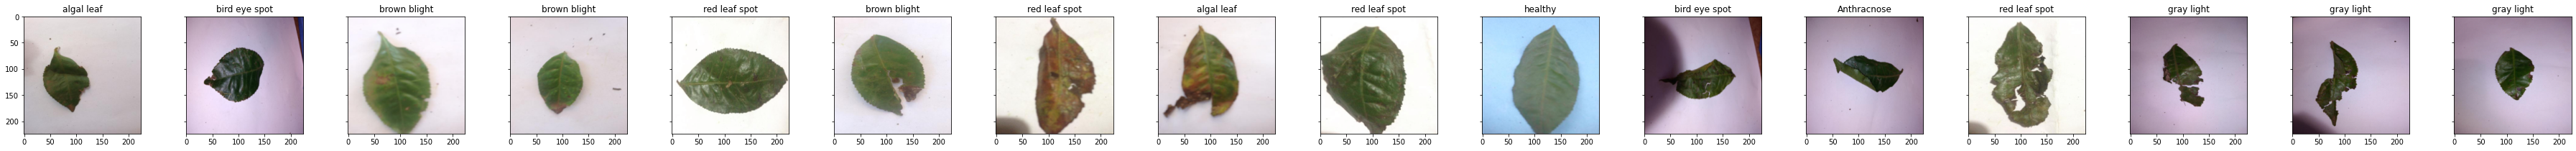

In [ ]:
def re_normalize (x, mean = mean, std= std):
    xx = x.numpy()
    for c, (mean_c, std_c) in enumerate(zip(mean, std)):
        xx [:,:,c] *= std_c
        xx [:,:,c] += mean_c
    return np.clip(xx, 0.0, 1.0)

def show_batch(x, y):
  fig, axs = plt.subplots(1, int(x.shape[0]), figsize=(64, 3), sharey=True)
  for i in range(int(x.shape[0])):
    axs[i].imshow(re_normalize(x[i].permute(1,2,0)))
    axs[i].set_title(class_names[y[i].item()])
  plt.show()

# show a random batch from the data loader
# (run this cell repeatedly to see different batches)
for x, y in train_dataloaders:
  show_batch(x, y)
  break

## Model

In [ ]:
class Vgg2D(torch.nn.Module):

  def __init__(
          self,
          input_size,
          fmaps=12,
          downsample_factors=[(2, 2), (2, 2), (2, 2), (2, 2)],
          output_classes=8):

    super(Vgg2D, self).__init__()

    self.input_size = input_size

    current_fmaps = 3
    #current_size = tuple(input_size)
    current_size = tuple(input_size[2:]) # Tamaño de entrada (HxW)
    #self.current_size = current_size

    features = []
    for i in range(len(downsample_factors)):

      features += [
          torch.nn.Conv2d(
              current_fmaps,
              fmaps,
              kernel_size=3,
              padding=1),
          torch.nn.BatchNorm2d(fmaps),
          torch.nn.ReLU(inplace=True),
          torch.nn.Conv2d(
              fmaps,
              fmaps,
              kernel_size=3,
              padding=1),
          torch.nn.BatchNorm2d(fmaps),
          torch.nn.ReLU(inplace=True),
          torch.nn.MaxPool2d(downsample_factors[i])
      ]

      current_fmaps = fmaps
      fmaps *= 2

      size = tuple(
          int(c/d)
          for c, d in zip(current_size, downsample_factors[i]))
      check = (
          s*d == c
          for s, d, c in zip(size, downsample_factors[i], current_size))
      assert all(check), \
          "Can not downsample %s by chosen downsample factor" % \
          (current_size,)
      current_size = size

    self.features = torch.nn.Sequential(*features)
   
    classifier = [
        torch.nn.Linear(
            current_size[0] *
            current_size[1] *
            current_fmaps,
            #16*16*96,
            4096),
        torch.nn.ReLU(inplace=True),
        torch.nn.Dropout(),
        torch.nn.Linear(
            4096,
            4096),
        torch.nn.ReLU(inplace=True),
        torch.nn.Dropout(),
        torch.nn.Linear(
            4096,
            output_classes)
    ]

    self.classifier = torch.nn.Sequential(*classifier)

  def forward(self, raw):

    # add a channel dimension to raw
    shape = tuple(raw.shape)
    #raw = raw.reshape(shape[0], 1, shape[1], shape[2])
    #raw = raw.permute(0,3,1,2).contiguous()

    # compute features
    f = self.features(raw)
    #print(f.shape)
    f = f.view(f.size(0), -1)
    #print(f.shape)
    #print(self.current_size)
    
    # classify
    y = self.classifier(f)

    return y

In [ ]:
# get the size of our images
for x, y in train_dataloaders:
  input_size = x.shape
  break

# create the model to train
model = Vgg2D(input_size)

# use a GPU, if it is available
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f"Will use device {device} for training")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Will use device cuda for training


In [ ]:
summary(model, input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 12, 224, 224]             336
       BatchNorm2d-2         [-1, 12, 224, 224]              24
              ReLU-3         [-1, 12, 224, 224]               0
            Conv2d-4         [-1, 12, 224, 224]           1,308
       BatchNorm2d-5         [-1, 12, 224, 224]              24
              ReLU-6         [-1, 12, 224, 224]               0
         MaxPool2d-7         [-1, 12, 112, 112]               0
            Conv2d-8         [-1, 24, 112, 112]           2,616
       BatchNorm2d-9         [-1, 24, 112, 112]              48
             ReLU-10         [-1, 24, 112, 112]               0
           Conv2d-11         [-1, 24, 112, 112]           5,208
      BatchNorm2d-12         [-1, 24, 112, 112]              48
             ReLU-13         [-1, 24, 112, 112]               0
        MaxPool2d-14           [-1, 24,

In [ ]:
def train(dataloader, optimizer, loss, device):
    '''Train the model for one epoch.'''
    # set the model into train mode
    model.train()
    epoch_loss, num_batches = 0, 0
    correct, total = 0, 0
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        l = loss(y_pred, y)
        l.backward()
        optimizer.step()
        epoch_loss += l
        probs = torch.nn.Softmax(dim=1)(y_pred)
        predictions = torch.argmax(probs, dim=1)
        correct += int(torch.sum(predictions == y).cpu().detach().numpy())
        total += len(y)
        num_batches += 1
    epoch_loss /= num_batches
    accuracy = correct/total    
    return epoch_loss.item(), accuracy

def validate(dataloader, loss, device):
    '''Evaluate prediction accuracy on the validation dataset.'''
    model.eval()
    with torch.no_grad():
        #dataloader = DataLoader(validation_dataset, batch_size=32)
        #accuracy = evaluate(dataloader, 'validate', device)
        epoch_loss, num_batches = 0, 0
        correct, total = 0, 0
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            l = loss(logits, y)
            epoch_loss += l.cpu().detach().numpy()
            probs = torch.nn.Softmax(dim=1)(logits)
            predictions = torch.argmax(probs, dim=1)
            correct += int(torch.sum(predictions == y).cpu().detach().numpy())
            total += len(y)
            num_batches += 1
        epoch_loss /= num_batches
        accuracy = correct/total
    return epoch_loss, accuracy


def test(dataloader, device, nb_classes = num_classes):
    '''Evaluate prediction accuracy on the test dataset.'''
    #nb_classes = num_classes
    y_pred_list = []
    y_true_list = []
    #confusion_matrix = torch.zeros(nb_classes, nb_classes)
    model.eval()
    with torch.no_grad():
        #dataloader = DataLoader(test_dataset, batch_size=32)
        #accuracy = evaluate(dataloader, 'test', device)
        correct, total = 0, 0
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            probs = torch.nn.Softmax(dim=1)(logits)
            predictions = torch.argmax(probs, dim=1)
            
            y_pred_list.extend(predictions.cpu().numpy().tolist())
            y_true_list.extend(y.cpu().numpy().tolist())
            
            #correct += int(torch.sum(predictions == y).cpu().detach().numpy())
            #total += len(y)
            #for t, p in zip(y.view(-1), predictions.view(-1)):
            #    confusion_matrix[t.long(), p.long()] += 1
        
        cnf_matrix = confusion_matrix(y_true_list, y_pred_list)
        cnf_matrix_t = torch.from_numpy(cnf_matrix)
        accuracy_per_clase = cnf_matrix_t.diag()/cnf_matrix_t.sum(1)
        accuracy_overall = cnf_matrix_t.diag().sum()/cnf_matrix_t.sum()
        print(f"final test accuracy per class: ")
        i=0;
        for name in class_names:
            print(f"\t{name}:\t{accuracy_per_clase[i]}")
            i = i + 1
        print(f"final test accuracy overall: {accuracy_overall}")
        print(classification_report(y_true_list, y_pred_list))
        #print(confusion_matrix(y_true_list, y_pred_list))
        plot_confusion_matrix(cnf_matrix, class_names)

        #accuracy = correct/total
        #accuracy_per_clase = confusion_matrix.diag()/confusion_matrix.sum(1)
        #accuracy_overall = confusion_matrix.diag().sum()/confusion_matrix.sum()
    #return confusion_matrix #, accuracy_per_clase, accuracy_overall
    #return y_pred_list, y_true_list 


def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

In [ ]:
def train_from_scratch(args, train_dataloader, val_dataloader, optimizer, 
                       scheduler, loss, device=device):
    patience = args['patience']
    num_epochs = args['epochs']
    best_acc = 0.0
    best_epoch = 0
    # Keeps track of number of epochs during which the val_acc was less than best_acc
    wait = 0
    val_loss_list, train_loss_list = [], []
    val_acc_list, train_acc_list = [], []
    plt.close()
    for epoch in tqdm.tqdm(range(num_epochs)):
        train_epoch_loss, train_acc = train(train_dataloader, optimizer, loss, device=device)
        current_lr=get_lr(optimizer)
        print(f"epoch {epoch}, lr={current_lr}, train loss={train_epoch_loss}, train accuracy={train_acc}")
        train_loss_list.append(train_epoch_loss)
        train_acc_list.append(train_acc)
        val_epoch_loss, val_acc = validate(val_dataloader, loss, device=device)
        val_loss_list.append(val_epoch_loss)
        val_acc_list.append(val_acc)
        print(f"epoch {epoch}, validation loss={val_epoch_loss}, validation accuracy={val_acc}")
        if (val_acc > best_acc):
            best_acc = val_acc
            best_epoch = epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            wait = 0
            print(f"Save model")
        else:
            wait += 1
        
        if (wait > patience):
            print(f'Early stopped on epoch: {epoch}')
            break
         
        scheduler.step()
        
        plt.plot(train_loss_list, 'r', label='train')
        plt.plot(val_loss_list, 'b', label='val')
        #plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Loss')

        IPython.display.clear_output(wait=True)
        IPython.display.display(plt.gcf())
    plt.legend()  
    plt.close()
    model.load_state_dict(best_model_wts)    
    return val_loss_list, train_loss_list, val_acc_list, train_acc_list, best_epoch

In [ ]:
# Fuente: https://www.kaggle.com/danbrice/keras-plot-history-full-report-and-grid-search
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title='Normalized confusion matrix'
    else:
        title='Confusion matrix'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
def inference(filename):
    # Load the image
    image = io.imread(filename)
    plt.imshow(transform.resize(image, (hh, ww))), plt.xticks([]), plt.yticks([])

    # First prepare the transformations: resize the image to what the model was trained on and convert it to a tensor
    test_data_transforms = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((hh, ww)),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
    # Now apply the transformation, expand the batch dimension, and send the image to the GPU
    #image = data_transform(image).unsqueeze(0).to(device)
    image = test_data_transforms(image).to(device) # [1,256,256]

    #model = models.resnet50(pretrained=True)
    # Send the model to the GPU 
    #model.cuda()
    # Set layers such as dropout and batchnorm in evaluation mode
    model.eval();

    # Get the 1000-dimensional model output
    out = model(torch.unsqueeze(image, 0))
    probs = torch.nn.Softmax(dim=1)(out)
    predictions = torch.argmax(probs, dim=1)
    # Find the predicted class
    print("Predicted prob is: {}".format(probs))
    print("Predicted class is: {}".format(class_names[predictions]))

## Test

In [ ]:
# create the model to train
model = Vgg2D(input_size)

# use a GPU, if it is available
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f"Will use device {device} for training")

# create a loss
loss = torch.nn.CrossEntropyLoss()

# create an optimzer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Decay LR by a factor of 0.1 every 20 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

Will use device cuda for training


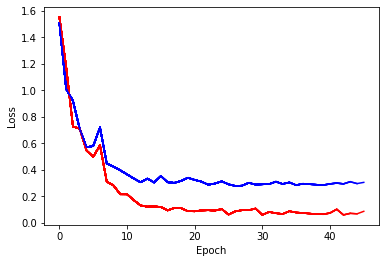

 46%|████▌     | 46/100 [08:25<06:09,  6.84s/it]

epoch 46, lr=1.0000000000000004e-08, train loss=0.08184529840946198, train accuracy=0.9769736842105263


 46%|████▌     | 46/100 [08:32<10:01, 11.14s/it]

epoch 46, validation loss=0.2935241967439651, validation accuracy=0.9015151515151515
Early stopped on epoch: 46


In [ ]:
args = {
    'epochs': 100,
    'patience': 25
}

val_loss, train_loss, val_acc, train_acc, best_epoch = train_from_scratch(
     args, train_dataloaders, val_dataloaders, optimizer, exp_lr_scheduler, loss, device=device)

Text(0, 0.5, 'Accuracy')

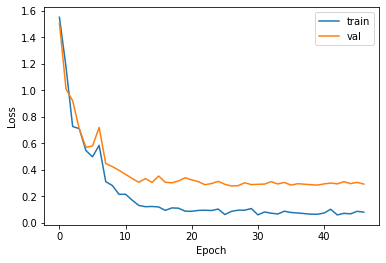

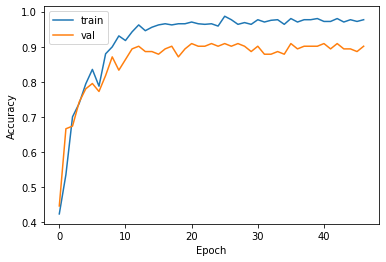

In [ ]:
plt.figure()
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.figure()
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

final test accuracy per class: 
	Anthracnose:	0.6842105388641357
	algal leaf:	1.0
	bird eye spot:	0.75
	brown blight:	0.9090909361839294
	gray light:	0.8999999761581421
	healthy:	1.0
	red leaf spot:	1.0
	white spot:	0.9473684430122375
final test accuracy overall: 0.9015151262283325
              precision    recall  f1-score   support

           0       0.76      0.68      0.72        19
           1       1.00      1.00      1.00        15
           2       0.75      0.75      0.75        12
           3       0.95      0.91      0.93        22
           4       0.82      0.90      0.86        10
           5       1.00      1.00      1.00        14
           6       1.00      1.00      1.00        21
           7       0.86      0.95      0.90        19

    accuracy                           0.90       132
   macro avg       0.89      0.90      0.89       132
weighted avg       0.90      0.90      0.90       132



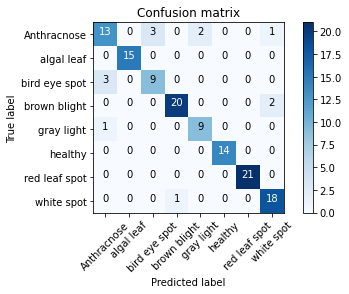

In [ ]:
test(test_dataloaders, device=device)

In [ ]:
path2models = "/content/drive/MyDrive/Proyecto NMA/Files_code/vgg_rgb_lr-04_pat25_stepsize10.pt"
torch.save(model.state_dict(), path2models)

In [ ]:
load_path = '/content/drive/MyDrive/Proyecto NMA/Files_code/vgg_rgb_lr-04_pat25.pt'
# create the model to train
model = Vgg2D(input_size)
model.to(device)
model.load_state_dict(torch.load(load_path))

<All keys matched successfully>

## Inference

Predicted prob is: tensor([[6.8704e-03, 5.7727e-04, 6.5667e-03, 1.1134e-05, 9.8537e-01, 4.6411e-05,
         4.2885e-04, 1.3232e-04]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
Predicted class is: gray light


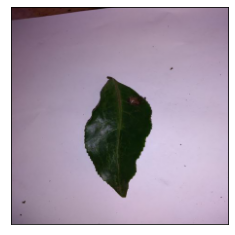

In [ ]:
label_image = 'Anthracnose'
test_image = test_dir + '/' + label_image + '/IMG_20220503_143344.jpg'
inference(test_image)

Predicted prob is: tensor([[8.8753e-06, 2.1221e-05, 6.3540e-06, 8.0632e-08, 8.3314e-06, 9.0353e-08,
         9.9995e-01, 5.3291e-07]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
Predicted class is: red leaf spot


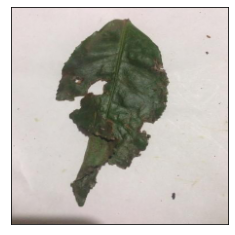

In [ ]:
label_image = 'red leaf spot'
test_image = test_dir + '/' + label_image + '/UNADJUSTEDNONRAW_thumb_179.jpg'
inference(test_image)

Predicted prob is: tensor([[5.3867e-17, 3.3769e-14, 1.0762e-19, 3.2825e-15, 5.9596e-17, 1.0000e+00,
         9.5718e-17, 5.7128e-15]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
Predicted class is: healthy


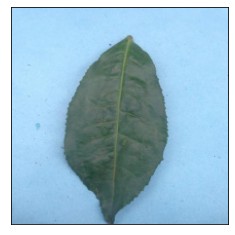

In [ ]:
label_image = 'healthy'
test_image = test_dir + '/' + label_image + '/UNADJUSTEDNONRAW_thumb_225.jpg'
inference(test_image)

Predicted prob is: tensor([[6.9675e-03, 1.0671e-01, 1.0608e-03, 1.9519e-04, 4.9528e-04, 1.3074e-04,
         8.5349e-01, 3.0947e-02]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
Predicted class is: red leaf spot


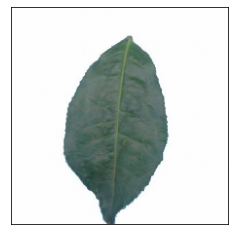

In [ ]:
data_dir = '/content/drive/MyDrive/Proyecto NMA/Resized images/healthy_combined'
label_image = 'healthy'
test_image = data_dir + '/' + 'UNADJUSTEDNONRAW_thumb_225.jpg'
inference(test_image)